In [1]:
import zipfile
z = zipfile.ZipFile('/content/drive/MyDrive/ml /pneumonia dataset/chest_xray.zip')
z.extractall()

In [ ]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [4]:
# labels = ['PNEUMONIA','NORMAL']
# img_size = 128
# def get_data(data_dir):
#     data=[]
#     for label in labels:
# #         train/PNEUMONIA
#         path = os.path.join(data_dir, label)
#         class_num = labels.index(label)
#         for img in os.listdir(path):
#             try:
#                 img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
#                 resized_arr = cv2.resize(img_arr, (img_size, img_size))
#                 data.append([resized_arr, class_num])
#             except Exception as e:
#                 print(e)
#     return np.array(data)

labels = ['PNEUMONIA', 'NORMAL']
img_size = 128
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [6]:
# train = get_data("chest_xray/chest_xray/train")
# test = get_data("chest_xray/chest_xray/test")
# val = get_data("chest_xray/chest_xray/val")
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:  # Check if the image was loaded correctly
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing image {img}: {e}")
    return np.array(data, dtype=object)  # Set dtype=object to handle any inhomogeneity

# Reload the train, test, and validation datasets with the updated function


In [7]:
train = get_data("/content/chest_xray/train")
test = get_data("/content/chest_xray/test")
val = get_data("/content/chest_xray/val")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
pneumonia = os.listdir("/content/chest_xray/train/PNEUMONIA")
penomina_dir = "/content/chest_xray/train/PNEUMONIA"

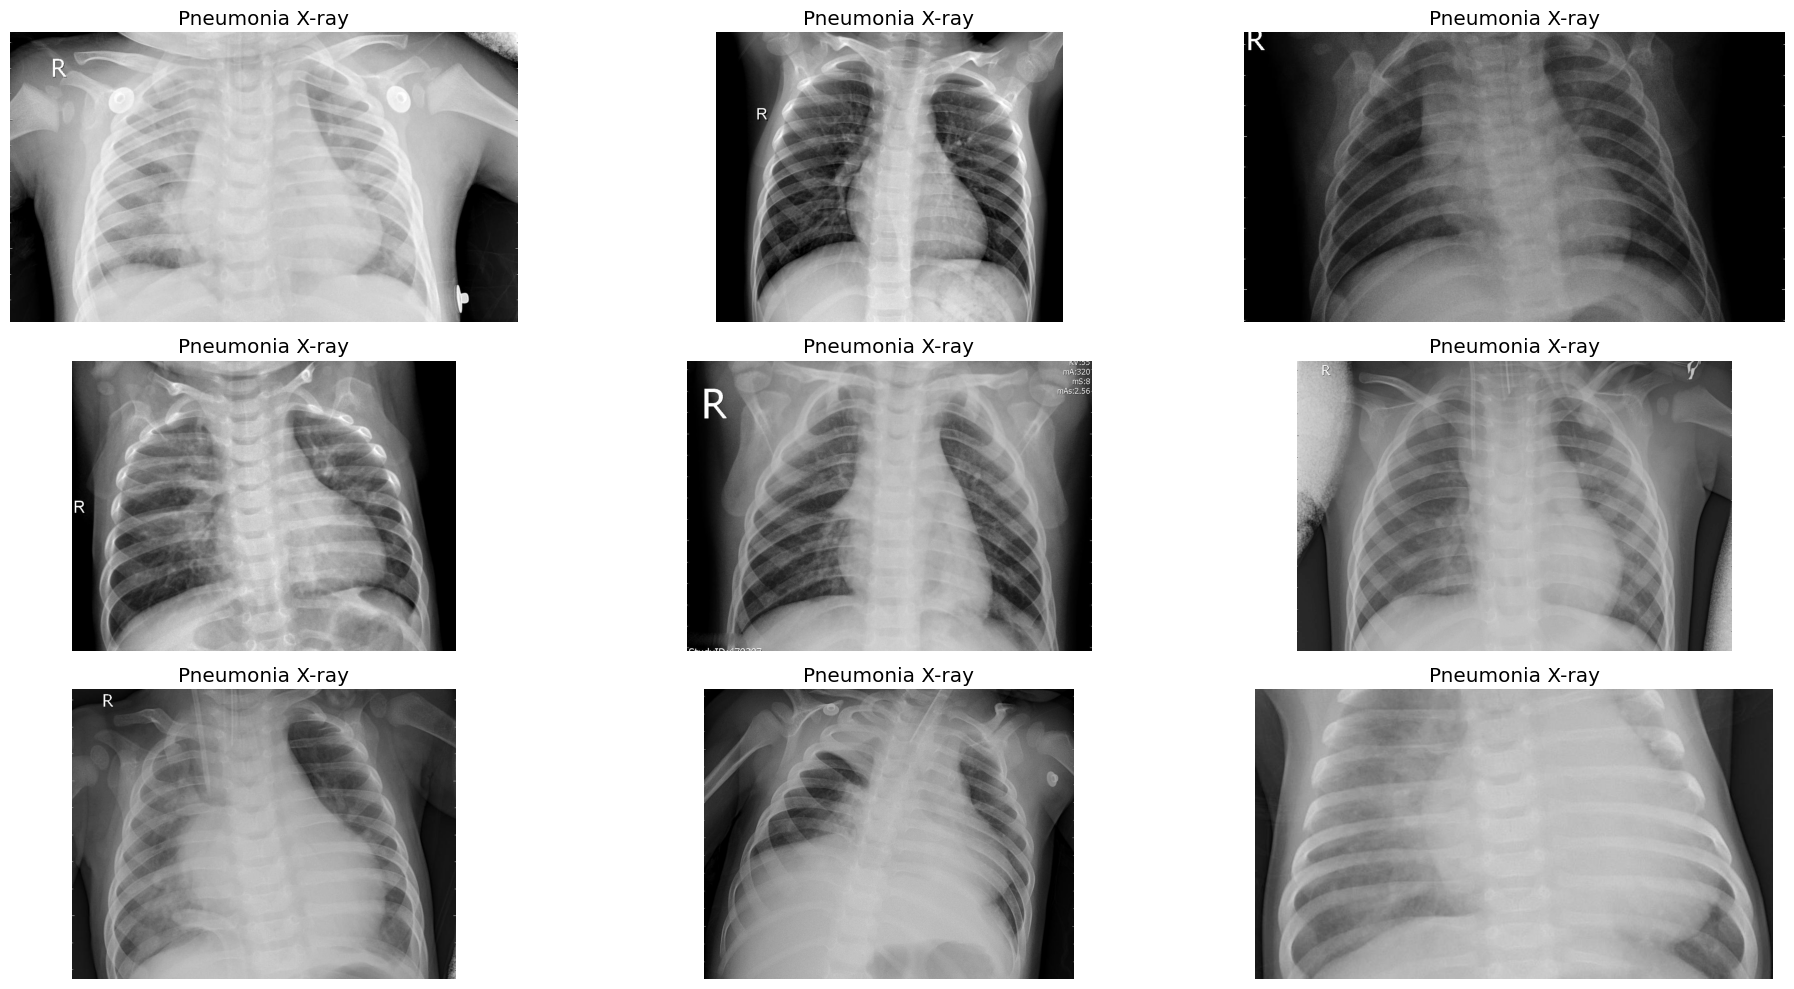

In [11]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [14]:
normal = os.listdir("/content/chest_xray/train/NORMAL")
normal_dir = "/content/chest_xray/train/NORMAL"

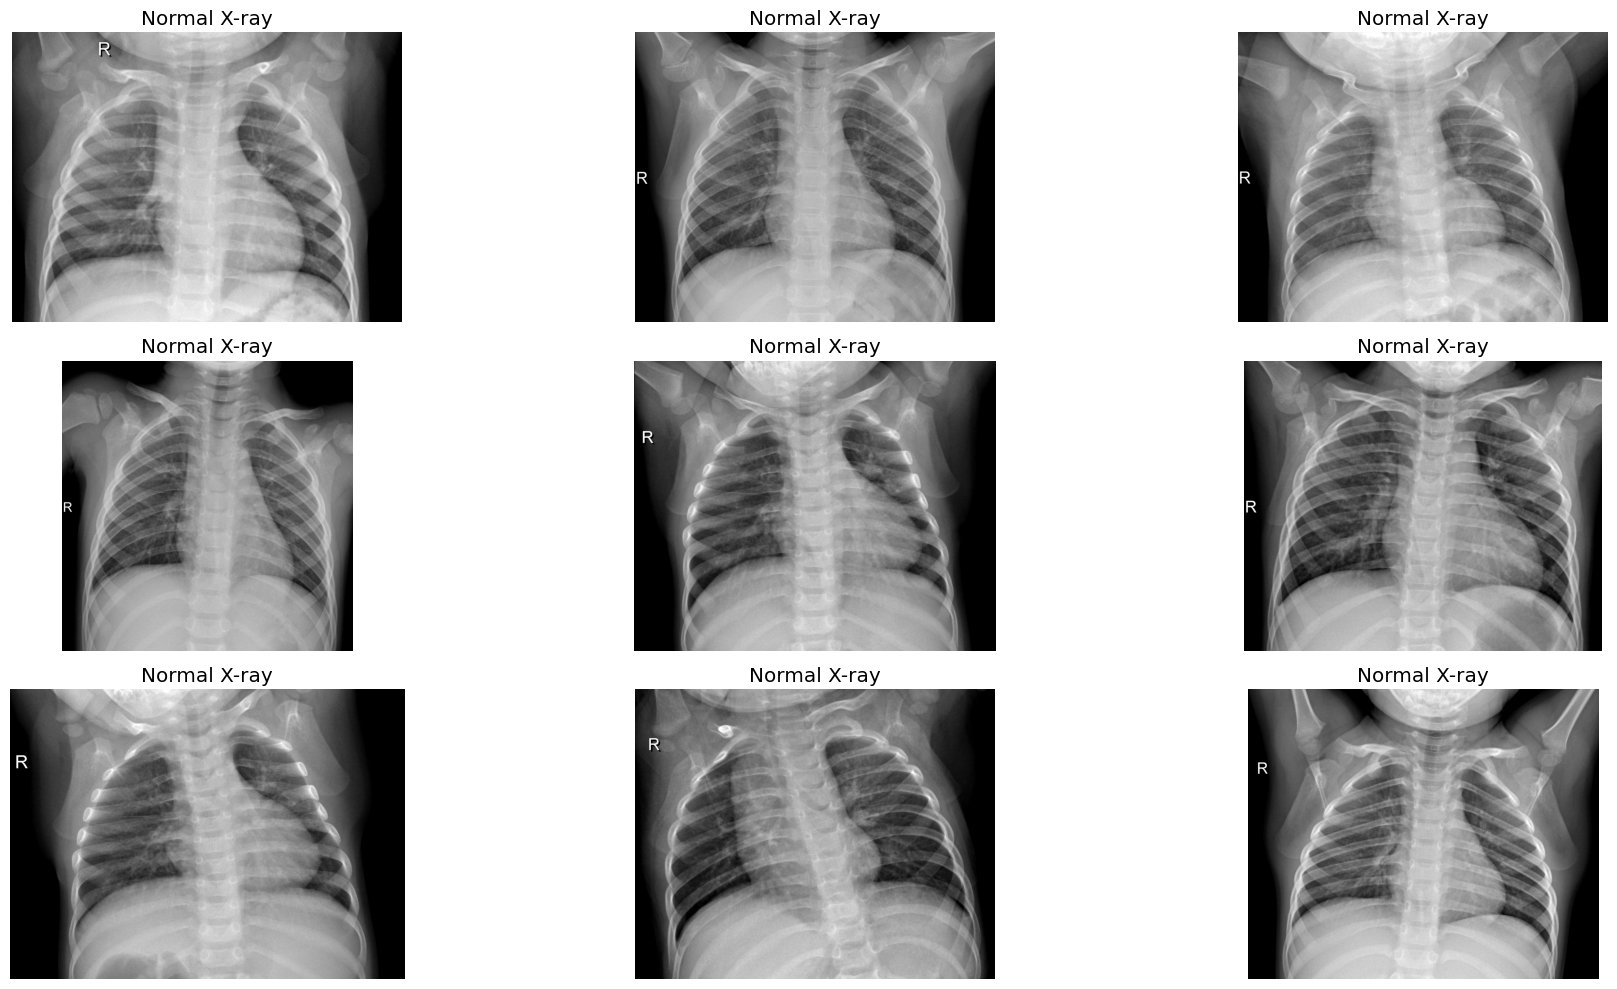

In [15]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

<Axes: xlabel='count'>

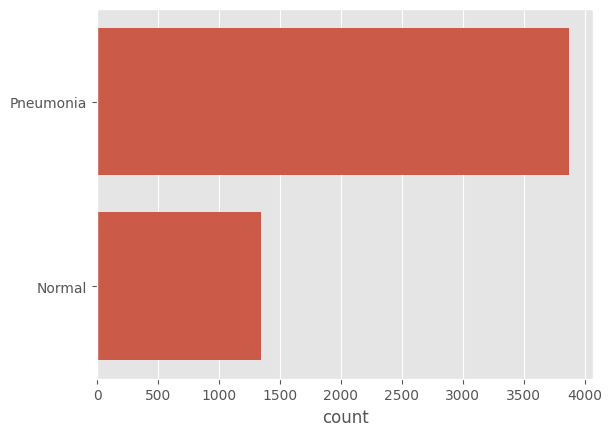

In [16]:
listx = []
for i in train:
    if(i[1] == 0):
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(listx)

In [17]:
# Data Augmentation & Resizing

In [18]:
pip install tensorflow


In [20]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [21]:
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [22]:
train_generator = train_datagen.flow_from_directory("/content/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("/content/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [23]:
class_labels = train_generator.class_indices

In [24]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [25]:
class_name = {value:key for (key, value) in class_labels.items()}

In [26]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [27]:
# VGG19 CNN Architecture

In [28]:
base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [31]:
# Define file path and callbacks
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

# Import legacy optimizer and define SGD with decay
from tensorflow.keras.optimizers.legacy import SGD

sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.0, nesterov=True)

# Compile model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])


In [32]:
history_01 = model_01.fit(train_generator,
            steps_per_epoch=50,
            epochs=1,
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)



50/50 [==============================] - 26s 507ms/step - loss: 0.5548 - accuracy: 0.7594 - val_loss: 0.7702 - val_accuracy: 0.5000 - lr: 1.0000e-04


In [33]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg19_model_01.h5", overwrite=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
test_generator = test_datagen.flow_from_directory("/content/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [35]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

20/20 [==============================] - 7s 321ms/step - loss: 0.6764 - accuracy: 0.6250


In [36]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.7701524496078491
Validation Accuarcy: 0.5
Test Loss: 0.6764418482780457
Test Accuarcy: 0.625


In [37]:
# Increamental unfreezing & fine tuning

In [38]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights("model_weights/vgg19_model_01.h5")

set_trainable = False
for layer in base_model.layers:
    if layer.name in [ 'block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False
print(model_02.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [39]:
base_model_layer_names

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [40]:
# sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0, nesterov = True)

# model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])


sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.0, nesterov=True)

model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [41]:
history_02 = model_02.fit(train_generator,
            steps_per_epoch=10,
            epochs=1,
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

10/10 [==============================] - 26s 2s/step - loss: 0.5071 - accuracy: 0.7969 - val_loss: 0.7997 - val_accuracy: 0.5000 - lr: 1.0000e-04


In [42]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg19_model_02.h5", overwrite=True)

In [43]:
model_02.load_weights("model_weights/vgg19_model_02.h5")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

20/20 [==============================] - 7s 323ms/step - loss: 0.6931 - accuracy: 0.6250
Validation Loss: 0.7997446060180664
Validation Accuarcy: 0.5
Test Loss: 0.6931150555610657
Test Accuarcy: 0.625


In [44]:
# Unfreezing and fine tuning the entire network

In [45]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_01.h5")

print(model_03.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [46]:
# sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0, nesterov = True)

# model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.0, nesterov=True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [47]:
history_03 = model_02.fit(train_generator,
            steps_per_epoch=100,
            epochs=1,
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

100/100 [==============================] - 229s 2s/step - loss: 0.5445 - accuracy: 0.7431 - val_loss: 0.6240 - val_accuracy: 0.5625 - lr: 1.0000e-04


In [48]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg_unfrozen.h5", overwrite=True)